In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import seaborn as sns

from backtesting import Backtest, Strategy
from backtesting.test import SMA
import tulipy as tu


Loading BokehJS ...

In [3]:
dataset_path = './data/HistoricalData_NG.csv'

In [4]:
def get_atr(data: pd.DataFrame, n: int):
    atr = tu.atr(data.High, data.Low, data.Close, n)
    return return_indicator(atr, len(data))

def return_indicator(values, data_len: int):
    a = np.empty((data_len - len(values),))
    a[:] = np.nan
    return np.concatenate([a, values])

In [5]:
class MovingAvg3LineCross(Strategy):
    n1 = 10
    n2 = 15
    n3 = 35
    risk = 5

    def init(self):
        super(MovingAvg3LineCross, self).init()
        self.trailingATRLen = 5
        self.lookback = 5
        self.atrStopMultiplier = 1.2
        self.shortSelling = False  # allowance of short selling
        self.pointvalue = 10

        self.fastSMA = self.I(SMA, self.data.Close, self.n1)
        self.medSMA = self.I(SMA, self.data.Close, self.n2)
        self.slowSMA = self.I(SMA, self.data.Close, self.n3)
        self.atr = self.I(get_atr, self.data, 14)
        self.trailingAtr = self.I(get_atr, self.data, self.trailingATRLen)

    def next(self):
        if len(self.trades) == 0:
            if self.slowSMA[-1] < self.medSMA[-1] < self.fastSMA[-1] < self.data.Close[-1] \
                    and self.get_slope() > 0.01:
                self.buy(size=self.get_position_size())
            if self.data.Close[-1] < self.fastSMA[-1] < self.medSMA[-1] < self.slowSMA[-1] \
                    and self.shortSelling and self.get_slope() < -0.01:
                self.sell(size=self.get_position_size())
        else:
            if self.trades[0].is_long:
                if self.data.Low[-1] <= self.get_trailing_stop(long=True):
                    self.position.close()
            else:
                if self.data.High[-1] >= self.get_trailing_stop(long=False) and self.shortSelling:
                    self.position.close()

    def get_slope(self):
        y = self.data.Close[-5:]
        X = np.arange(1, len(y) + 1, 1)
        y_m, x_m = np.mean(y), np.mean(X)
        m = np.sum([(y_i - y_m)*(x_i - x_m) for y_i, x_i in zip(y, X)]) / np.sum([(x_i - x_m) ** 2 for x_i in X])
        return m

    def get_position_size(self):
        return math.floor((self.risk / 100 * self.equity) / (self.atr * self.pointvalue))

    def get_trailing_stop(self, long: bool):
        if long:
            return np.max(self.data.Low[-self.lookback:]) - self.trailingAtr[-1] * self.atrStopMultiplier
        else:
            return np.min(self.data.High[-self.lookback:]) + self.trailingAtr[-1] * self.atrStopMultiplier

In [6]:
data = pd.read_csv(dataset_path, sep=',', index_col=0, parse_dates=True)
data = data.dropna()

data = data.set_index(pd.to_datetime(data.index))
data.sort_values(by='Date', inplace=True)
test_data = data['2017-01-02': '2021-09-14']


bt = Backtest(test_data, MovingAvg3LineCross, cash=250_000, commission=0.02, trade_on_close=True, margin=0.05)

In [7]:
stats, heatmap = bt.optimize(
            n1=range(3, 11, 1),
            n2=range(15, 26, 1),
            n3=range(30, 65, 5),
            risk=list(np.arange(0.5, 5.5, 0.5)),
            constraint=lambda p: p.n1 < p.n2 < p.n3,
            maximize='Equity Final [$]',
            max_tries=250,
            random_state=0,
            return_heatmap=True)

stats

Start                     2017-01-03 00:00:00
End                       2021-08-30 00:00:00
Duration                   1700 days 00:00:00
Exposure Time [%]                   28.534923
Equity Final [$]                 264120.88986
Equity Peak [$]                   268108.6086
Return [%]                           5.648356
Buy & Hold Return [%]               29.395852
Return (Ann.) [%]                    1.186403
Volatility (Ann.) [%]                5.711414
Sharpe Ratio                         0.207725
Sortino Ratio                        0.319637
Calmar Ratio                         0.132121
Max. Drawdown [%]                   -8.979659
Avg. Drawdown [%]                   -4.051874
Max. Drawdown Duration     1020 days 00:00:00
Avg. Drawdown Duration      403 days 00:00:00
# Trades                                   19
Win Rate [%]                        31.578947
Best Trade [%]                      34.803922
Worst Trade [%]                    -14.717448
Avg. Trade [%]                    

In [8]:
heatmap

n1  n2  n3  risk
3   15  35  3.5     257542.50200
        45  2.5     255382.83534
    16  30  3.0     257342.62158
        40  4.0     257849.72224
            5.0     259681.00124
                        ...     
10  25  30  0.5     249590.74438
            2.0     248256.62592
        40  1.5     248953.98032
            4.5     246414.25178
        60  0.5     250243.30124
Name: Equity Final [$], Length: 267, dtype: float64

In [9]:
heatmap.sort_values()

n1  n2  n3  risk
9   25  40  4.5     241131.44274
8   24  40  4.5     242373.76024
9   25  35  5.0     243881.00700
8   25  35  3.0     244667.39658
10  19  45  4.0     244730.71290
                        ...     
3   20  55  5.0     260763.94256
    16  55  3.5     261308.92892
10  15  30  4.5     261357.26374
9   22  45  5.0     261470.15308
3   20  50  4.5     264120.88986
Name: Equity Final [$], Length: 267, dtype: float64

In [10]:
hm_1 = heatmap.groupby(['n1', 'n2']).mean().unstack()

hm_1

n2,15,16,17,18,19,20,21,22,23,24,25
n1,,,,,,,,,,,
3,256462.668670,259045.568495,253333.141080,251531.199647,251262.237270,257177.323243,NaN,254860.483000,254549.878900,252689.647467,252725.950393
4,251974.890860,252920.555760,259028.712600,251940.769544,254117.574600,252501.113020,255646.234670,252912.354036,252913.852750,246220.386340,251764.953587
5,255076.756010,252634.661980,253446.460608,253176.506740,NaN,254822.569068,252160.856988,252556.485560,252238.798853,251486.636630,252585.943600
6,258462.775660,252403.698793,253142.476455,250270.008280,251575.307280,248094.224420,253300.041140,251831.972380,254526.069865,253595.691840,246786.200400
7,NaN,252961.713610,251488.991822,250384.839270,252976.918620,250538.815248,251343.317860,250461.058520,253341.504000,248794.443533,245728.072700
8,259452.097070,255748.240394,255901.313940,251407.852160,249779.234640,254226.503630,250667.900430,254079.346077,250267.998480,245772.123790,248132.190884
9,254238.515000,252461.429627,251065.612031,249642.844440,256764.005395,258300.143220,255003.270800,254258.316195,248864.430720,248991.710200,244492.044280
10,256218.043704,251230.919430,255123.447100,248794.149850,249313.598066,247291.905670,248423.402556,251377.035905,252051.595893,252673.081273,248691.780728


<AxesSubplot:xlabel='n2', ylabel='n1'>

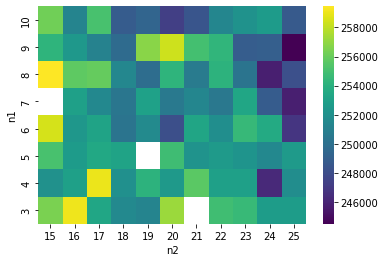

In [11]:
sns.heatmap(hm_1[::-1], cmap='viridis')

In [12]:
hm_2 = heatmap.groupby(['n2', 'n3']).mean().unstack()

hm_2

n3,30,35,40,45,50,55,60
n2,,,,,,,
15,260331.596180,257139.501170,NaN,255364.939586,254801.914040,252821.820480,NaN
16,255957.669230,253410.044073,254577.650737,252540.710187,253872.091750,254540.166844,255111.032447
17,251770.470300,254347.909590,250992.525722,251822.283580,254524.603673,255159.985667,253577.374055
18,250233.106640,250950.789210,250749.379657,249938.749430,252614.469680,252341.015833,252432.365220
19,251430.613500,251577.420593,250535.118800,247027.234307,253729.413036,252748.412856,257168.014420
20,254756.015400,248561.055090,247805.482580,248481.786828,257882.675567,256215.793796,254592.107893
21,257284.479460,250796.008987,245523.296970,251186.999280,252448.519030,253035.079605,253012.777473
22,251886.349865,248785.230825,250350.432393,255641.418314,254337.565715,253926.718245,253356.745958
23,249433.049590,249075.677633,252497.795170,253012.888800,254441.807464,252921.154576,251324.652060


<AxesSubplot:xlabel='n3', ylabel='n2'>

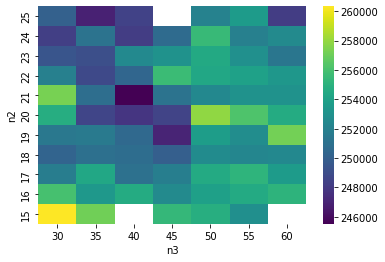

In [13]:
sns.heatmap(hm_2[::-1], cmap='viridis')

In [14]:
hm_3 = heatmap.groupby(['n1', 'n3']).mean().unstack()

hm_3

n3,30,35,40,45,50,55,60
n1,,,,,,,
3,252450.353605,253922.385510,254805.435794,254796.358392,256587.714610,255883.304269,253894.227736
4,251429.671980,252662.372675,252542.870180,252033.356105,255715.810280,252124.814480,254007.640465
5,253315.204372,251561.049260,252046.480440,252322.022770,254709.199833,253321.664345,253362.297847
6,251989.688670,254017.117073,252286.479260,251609.308237,255425.853596,252549.951190,251133.995250
7,250210.249000,248262.228120,249022.720654,251859.780430,254574.952520,252821.828747,251734.597872
8,253423.763330,249940.702577,250673.071080,253086.420560,254205.208589,253631.046253,253787.963729
9,249379.986540,248016.149280,247588.966904,254713.173844,253914.214960,255980.449905,254470.167757
10,252659.470684,252560.581010,247558.244623,248671.498369,253111.083207,252235.682137,250908.168627


<AxesSubplot:xlabel='n3', ylabel='n1'>

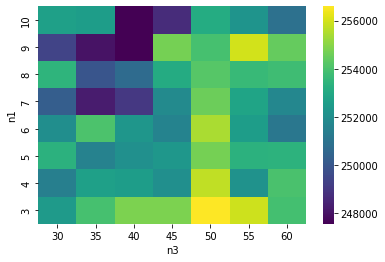

In [15]:
sns.heatmap(hm_3[::-1], cmap='viridis')
